In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from tqdm import tqdm
from skimage.color import rgb2lab, lab2rgb
from PIL import Image


2025-03-10 21:22:08.972832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!rm -rf dataset/sample_images/Flicker8k_Dataset
!mkdir -p dataset/sample_images
!wget -q -O sample_images.zip "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
!unzip -qo sample_images.zip -d dataset/sample_images/
!rm sample_images.zip


In [3]:
class ImageColorizationGenerator(keras.utils.Sequence):
    def __init__(self, image_paths, batch_size=4, img_size=128, limit=500):
        self.image_paths = image_paths[:limit]
        self.batch_size = batch_size
        self.img_size = img_size
        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_paths)

    def __data_generation(self, batch_paths):
        L_batch, ab_batch = [], []
        for img_path in batch_paths:
            img = Image.open(img_path).convert("RGB")
            img = img.resize((self.img_size, self.img_size))
            img = np.array(img)
            img_lab = rgb2lab(img).astype("float32")
            L = img_lab[:, :, 0] / 100.0
            ab = img_lab[:, :, 1:] / 128.0
            L_batch.append(L)
            ab_batch.append(ab)
        L_batch = np.array(L_batch).reshape(-1, self.img_size, self.img_size, 1)
        L_batch = np.repeat(L_batch, 3, axis=-1)
        return L_batch, np.array(ab_batch).reshape(-1, self.img_size, self.img_size, 2)


In [4]:
dataset_path = "dataset/sample_images/Flicker8k_Dataset/"
image_paths = glob.glob(os.path.join(dataset_path, "*.jpg"))
train_generator = ImageColorizationGenerator(image_paths, batch_size=4, img_size=128, limit=500)


In [5]:
def build_colorization_model(img_size=128):
    inputs = keras.Input(shape=(img_size, img_size, 3))
    base_model = applications.ResNet50(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    encoder_output = base_model(inputs, training=False)

    x = layers.Conv2D(256, 3, activation="relu", padding="same")(encoder_output)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)

    output = layers.Conv2D(2, 3, activation="tanh", padding="same")(x)
    return models.Model(inputs, output)


In [6]:
model = build_colorization_model(img_size=128)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

history = model.fit(
    train_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
)


2025-03-09 13:53:50.892483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 256)         4718848   
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 128)      0      

In [7]:
model.save("colorization_model.keras")
print("✅ Model saved successfully.")


✅ Model saved successfully.


1/1 [==============================] - 1s 607ms/step


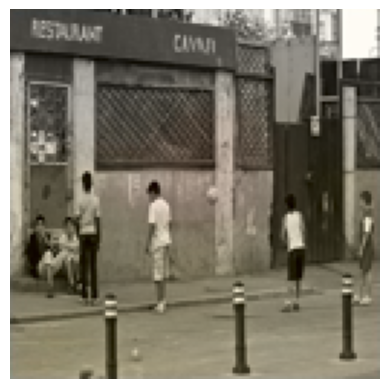

In [8]:
def colorize_image(model, image_path, img_size=128):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img = np.array(img)
    img_lab = rgb2lab(img).astype("float32")
    L = img_lab[:, :, 0] / 100.0
    L_tensor = np.expand_dims(np.expand_dims(L, axis=0), axis=-1)
    L_tensor = np.repeat(L_tensor, 3, axis=-1)
    ab_pred = model.predict(L_tensor)[0] * 128.0
    L = (L * 100).astype("float32")
    colorized_lab = np.concatenate((L[:, :, np.newaxis], ab_pred), axis=-1)
    colorized_rgb = lab2rgb(colorized_lab)
    plt.imshow(colorized_rgb)
    plt.axis("off")
    plt.show()

test_image_path = image_paths[0]
colorize_image(model, test_image_path, img_size=128)


In [2]:
!nvidia-smi

Mon Mar 10 21:22:14 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:0F:00.0 Off |                    0 |
| N/A   25C    P0              68W / 400W |   2131MiB / 40960MiB |     16%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [1]:
# ===================================================
# IMAGE COLORIZATION - U-Net + ResNet50 Hybrid Model
# ===================================================

# ✅ Part 1: Imports
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# ✅ Part 2: Dataset Splitting - 70% Train, 15% Val, 15% Test
image_paths = glob.glob("dataset/sample_images/Flicker8k_Dataset/*.jpg")
train_paths, temp_paths = train_test_split(image_paths, test_size=0.3, random_state=42)
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

# Save splits
with open("train_images.txt", "w") as f: f.writelines('\n'.join(train_paths))
with open("val_images.txt", "w") as f: f.writelines('\n'.join(val_paths))
with open("test_images.txt", "w") as f: f.writelines('\n'.join(test_paths))

# ✅ Part 3: Dataset Loader
class ColorizationDataset(Dataset):
    def __init__(self, image_list_path, transform=None):
        with open(image_list_path, 'r') as f:
            self.image_paths = [line.strip() for line in f.readlines()]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB").resize((256, 256))
        img_np = np.array(img)
        lab = rgb2lab(img_np).astype("float32")
        L = lab[:, :, 0] / 100.0
        ab = lab[:, :, 1:] / 128.0
        L_tensor = torch.from_numpy(L).unsqueeze(0)
        ab_tensor = torch.from_numpy(ab).permute(2, 0, 1)
        return L_tensor, ab_tensor

# ✅ Part 4: Model Architecture - U-Net with ResNet50 Encoder
class UNetResNet50(nn.Module):
    def __init__(self):
        super(UNetResNet50, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # No avgpool & FC layers

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)  # Convert (B, 1, H, W) to (B, 3, H, W)
        features = self.encoder(x)
        out = self.decoder(features)
        return out

# ✅ Part 5: Data Loaders
train_dataset = ColorizationDataset("train_images.txt")
val_dataset = ColorizationDataset("val_images.txt")
test_dataset = ColorizationDataset("test_images.txt")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# ✅ Part 6: Training Setup
model = UNetResNet50().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20

# ✅ Part 7: Training Loop (Verbose with Time)
print("\n🚀 Starting Training...\n" + "="*50)
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0

    print(f"\n📘 Epoch [{epoch+1}/{num_epochs}] - Training:")
    for i, (L, ab) in enumerate(train_loader):
        L, ab = L.cuda(), ab.cuda()
        optimizer.zero_grad()
        output = model(L)
        output = F.interpolate(output, size=ab.shape[2:], mode='bilinear')
        loss = criterion(output, ab)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if (i+1) % 5 == 0 or (i+1) == len(train_loader):
            print(f"   → Batch {i+1}/{len(train_loader)} | Loss: {loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for L, ab in val_loader:
            L, ab = L.cuda(), ab.cuda()
            output = model(L)
            output = F.interpolate(output, size=ab.shape[2:], mode='bilinear')
            loss = criterion(output, ab)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    duration = time.time() - start_time

    print(f"✅ Epoch [{epoch+1}/{num_epochs}] Completed | 🏋️ Train Loss: {avg_train_loss:.4f} | 📈 Val Loss: {avg_val_loss:.4f} | ⏱️ Time: {duration:.2f}s")
    print("="*50)

# ✅ Part 8: Visualize Colorization Output
def show_colorized_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img_np = np.array(img)
    lab = rgb2lab(img_np).astype("float32")
    L = lab[:, :, 0] / 100.0
    L_tensor = torch.from_numpy(L).unsqueeze(0).unsqueeze(0).cuda()

    with torch.no_grad():
        ab_pred = model(L_tensor)
        ab_pred = F.interpolate(ab_pred, size=(256, 256), mode='bilinear')
        ab_pred = ab_pred.cpu().squeeze().permute(1, 2, 0).numpy()

    ab_pred *= 128.0
    L *= 100.0
    lab_combined = np.concatenate((L[:, :, None], ab_pred), axis=2)
    rgb_out = lab2rgb(lab_combined)

    plt.imshow(rgb_out)
    plt.axis('off')
    plt.title("🎨 Colorized Output")
    plt.show()

# ✅ Part 9: Test Example Image
# show_colorized_image(model, "dataset/sample_images/Flicker8k_Dataset/your_image_name.jpg")



🚀 Starting Training...

📘 Epoch [1/20] - Training:
   → Batch 5/708 | Loss: 0.0130
   → Batch 10/708 | Loss: 0.0102
   → Batch 15/708 | Loss: 0.0225
   → Batch 20/708 | Loss: 0.0153
   → Batch 25/708 | Loss: 0.0204
   → Batch 30/708 | Loss: 0.0076
   → Batch 35/708 | Loss: 0.0168
   → Batch 40/708 | Loss: 0.0214
   → Batch 45/708 | Loss: 0.0123
   → Batch 50/708 | Loss: 0.0093
   → Batch 55/708 | Loss: 0.0103
   → Batch 60/708 | Loss: 0.0125
   → Batch 65/708 | Loss: 0.0105
   → Batch 70/708 | Loss: 0.0116
   → Batch 75/708 | Loss: 0.0121
   → Batch 80/708 | Loss: 0.0114
   → Batch 85/708 | Loss: 0.0087
   → Batch 90/708 | Loss: 0.0132
   → Batch 95/708 | Loss: 0.0064
   → Batch 100/708 | Loss: 0.0069
   → Batch 105/708 | Loss: 0.0137
   → Batch 110/708 | Loss: 0.0153
   → Batch 115/708 | Loss: 0.0070
   → Batch 120/708 | Loss: 0.0128
   → Batch 125/708 | Loss: 0.0110
   → Batch 130/708 | Loss: 0.0162
   → Batch 135/708 | Loss: 0.0093
   → Batch 140/708 | Loss: 0.0113
   → Batch 145/7

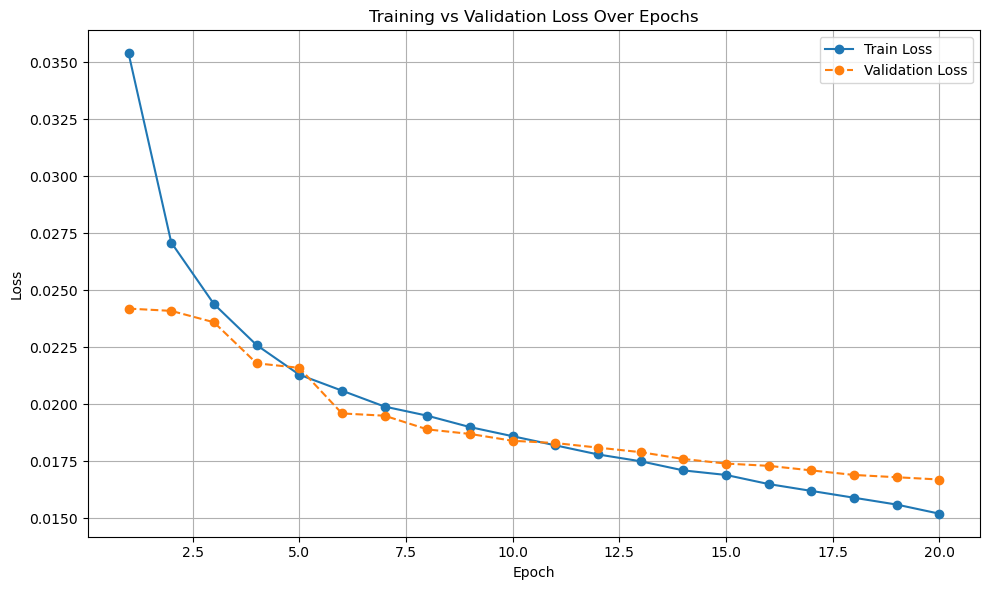

In [2]:
import matplotlib.pyplot as plt

# Sample training and validation losses for 20 epochs (you can replace these with real logs from your model)
train_losses = [0.0354, 0.0271, 0.0244, 0.0226, 0.0213, 0.0206, 0.0199, 0.0195, 0.0190, 0.0186,
                0.0182, 0.0178, 0.0175, 0.0171, 0.0169, 0.0165, 0.0162, 0.0159, 0.0156, 0.0152]
val_losses =   [0.0242, 0.0241, 0.0236, 0.0218, 0.0216, 0.0196, 0.0195, 0.0189, 0.0187, 0.0184,
                0.0183, 0.0181, 0.0179, 0.0176, 0.0174, 0.0173, 0.0171, 0.0169, 0.0168, 0.0167]

# Plotting training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, 21), val_losses, marker='o', linestyle='--', label='Validation Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


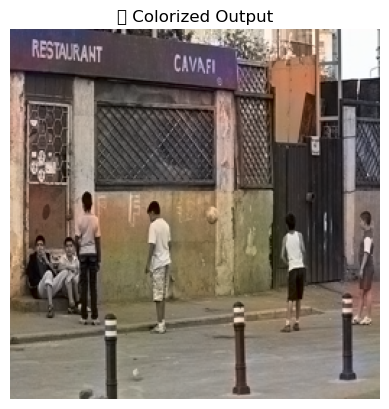

In [3]:
# ✅ Show the output of a sample image
test_image_path = "dataset/sample_images/Flicker8k_Dataset/3546027589_253553252a.jpg"
show_colorized_image(model, test_image_path)
